Every shot in the shot-by-shot summaries has an accuracy score assigned to it based on how closely to perfect it was executed, which I have stored in the "percent_score" column of the shots table in the database.  Ultimately, I would like to see if we can predict who will win a game based on these accuracy numbers.

This analysis can get pretty fine-grained:
* Anyone who has watched curling games with commentary knows that the commentators report these average accuracy numbers ("stats") individually for each player, breaking them down by "draw" and "take-out".
* Do different positions' stats contribute to the success of the team more than others?  Are some of them irrelevant? (e.g. a Skip needs to do all shots accurately, but a Lead with poor take-out stats may pose less of an issue, as most of their shots should be Draw-like.)
* How stable is the performance of the team?  Does past performance predict future performance well?  (it is commonplace for commentators to cite stats for a player computed over all shots in the event prior to the shot in question

So, the analysis we we start with will be pretty simplistic: Given the average stats for both teams in a game, can we predict the winner of the game?  If so, we can investigate how suitable this model would be for predicting the winner in future games.  If not, we can look into a more complex model that takes some of the additional factors above into consideration.

In [1]:
#Start by setting up the path to the database, and loading in the database helper functions.
import os
os.environ["CADBPATH"]=os.getcwd() + "/curling_data.db"

import database_functions as db

In [9]:
#The first thing we need to do is get the average stats into a usable form. The stone color should not correlate with
#win-loss or stats at all, though this is something we check.  Assuming this is true, this gives us an easy way to
#select data:  Make it a question of "Red Win/Loss", looking at "Red average percent_score vs. Yellow average 
#percent score".
#So, the fields we need are:
# * Average of percent_score from the shots table, over all shots with the same color and same game_id
# * The color the average percent_score corresponds to.
# * final_score_red and final_score_yellow from the games table.
#So, we need to join the games, ends, and shots tables.
#Filter out all the games where the final score is NaN
q = """
SELECT games.id AS game_id, games.final_score_red, games.final_score_yellow, shots.color,  AVG(shots.percent_score) AS avg_pct FROM games
INNER JOIN ends on games.id = ends.game_id
INNER JOIN shots on ends.id = shots.end_id
WHERE games.final_score_red != 'NaN' AND final_score_yellow != "NaN"
GROUP BY games.id, shots.color
"""
df = db.run_query(q)
df

,game_id,final_score_red,final_score_yellow,color,avg_pct
0,169,4,6,red,75.000000
1,169,4,6,yellow,81.329114
2,170,3,10,red,72.321429
3,170,3,10,yellow,77.678571
4,171,4,9,red,83.593750
...,...,...,...,...,...
2195,1266,6,4,yellow,70.253165
2196,1267,6,3,red,85.312500
2197,1267,6,3,yellow,75.000000
2198,1268,3,8,red,71.180556


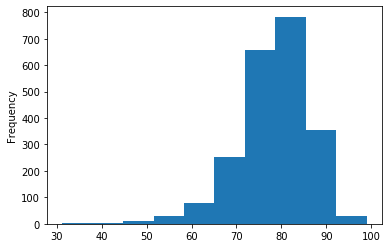

In [13]:
#Let's start by getting a quick look at the distribution of the average stats.
df["avg_pct"].plot(kind = "hist")

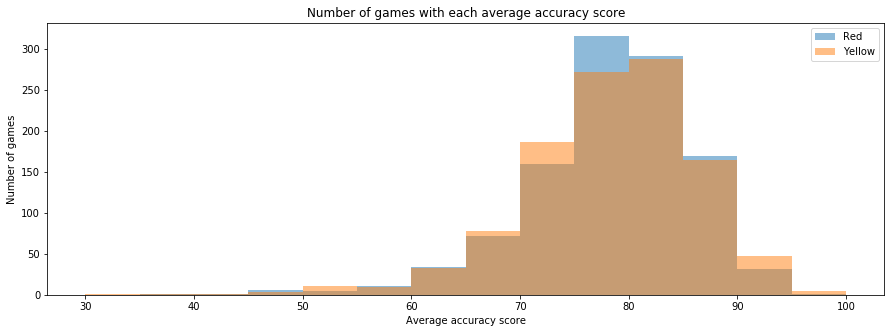

In [29]:
#Now, break it down by color to get a quick verification that the color is not correlated to the stats.
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(15,5))
red_stat = plt.hist(df[df["color"]== "red"]["avg_pct"], bins=np.arange(30,105,5), alpha=0.5, label = "Red")
yellow_stat = plt.hist(df[df["color"]== "yellow"]["avg_pct"], bins=np.arange(30,105,5), alpha=0.5, label="Yellow")
ax.set_ylabel("Number of games")
ax.set_xlabel("Average accuracy score")
ax.set_title("Number of games with each average accuracy score")
ax.legend()

So it looks like there may actually be a bit of a difference between red and yellow stats scores.  Rather than speculate on why that might be and try to disentangle it, we can just adapt our approach to randomly consider both colors:
1. Randomly select games in the dataframe to use for training by game_id.
2. For each game_id, randomly select "red" or "yellow" to be the "Team" that wins or loses.  The "Opposing Team" is the other team.

In [36]:
#This gives us a list of the game_ids in the dataframe.
game_ids = df["game_id"].unique()
game_ids

array([ 169,  170,  171, ..., 1266, 1267, 1268])

In [37]:
game_ids.size

1100

In [40]:
#Now, create a random array of bool, so for each game_id we can assign the "primary team"
primary_team = np.random.randint(0,2,size=game_ids.size)
primary_team

array([0, 0, 1, ..., 0, 1, 1])

In [42]:
#Double this up so each game (game_id is reported twice) gets assigned the same primary team.
df_primary_team = primary_team.repeat(2)
df_primary_team

array([0, 0, 0, ..., 1, 1, 1])

In [44]:
df_primary_team.size

2200

In [47]:
import pandas as pd
pt_map = {0:"red", 1:"yellow"}
df["primary_team"] = pd.Series(df_primary_team).map(pt_map)

In [48]:
df

,game_id,final_score_red,final_score_yellow,color,avg_pct,primary_team
0,169,4,6,red,75.000000,red
1,169,4,6,yellow,81.329114,red
2,170,3,10,red,72.321429,red
3,170,3,10,yellow,77.678571,red
4,171,4,9,red,83.593750,yellow
...,...,...,...,...,...,...
2195,1266,6,4,yellow,70.253165,red
2196,1267,6,3,red,85.312500,yellow
2197,1267,6,3,yellow,75.000000,yellow
2198,1268,3,8,red,71.180556,yellow


In [49]:
#Now, let's get the data all into rows, for easier factorization.  Create a new primary_avg_pct column to hold the
#primary team's average percent.
df["primary_avg_pct"] = df[df["color"] == df["primary_team"]]["avg_pct"]
df

,game_id,final_score_red,final_score_yellow,color,avg_pct,primary_team,primary_avg_pct
0,169,4,6,red,75.000000,red,75.000000
1,169,4,6,yellow,81.329114,red,NaN
2,170,3,10,red,72.321429,red,72.321429
3,170,3,10,yellow,77.678571,red,NaN
4,171,4,9,red,83.593750,yellow,NaN
...,...,...,...,...,...,...,...
2195,1266,6,4,yellow,70.253165,red,NaN
2196,1267,6,3,red,85.312500,yellow,NaN
2197,1267,6,3,yellow,75.000000,yellow,75.000000
2198,1268,3,8,red,71.180556,yellow,NaN


In [50]:
#Do the same for opposing_avg_pct
df["opposing_avg_pct"] = df[df["color"] != df["primary_team"]]["avg_pct"]
df

,game_id,final_score_red,final_score_yellow,color,avg_pct,primary_team,primary_avg_pct,opposing_avg_pct
0,169,4,6,red,75.000000,red,75.000000,NaN
1,169,4,6,yellow,81.329114,red,NaN,81.329114
2,170,3,10,red,72.321429,red,72.321429,NaN
3,170,3,10,yellow,77.678571,red,NaN,77.678571
4,171,4,9,red,83.593750,yellow,NaN,83.593750
...,...,...,...,...,...,...,...,...
2195,1266,6,4,yellow,70.253165,red,NaN,70.253165
2196,1267,6,3,red,85.312500,yellow,NaN,85.312500
2197,1267,6,3,yellow,75.000000,yellow,75.000000,NaN
2198,1268,3,8,red,71.180556,yellow,NaN,71.180556


In [52]:
#Now, get the opposing_avg_pct number out of the dataframe, so we can extract the 1100 regular values.
opposing_avg_pct = df["opposing_avg_pct"]
opposing_avg_pct

0             NaN
1       81.329114
2             NaN
3       77.678571
4       83.593750
          ...    
2195    70.253165
2196    85.312500
2197          NaN
2198    71.180556
2199          NaN
Name: opposing_avg_pct, Length: 2200, dtype: float64

In [56]:
opposing_avg_pct = opposing_avg_pct.dropna()

In [57]:
opposing_avg_pct = opposing_avg_pct.repeat(2)

In [65]:
df["opposing_avg_pct"] = opposing_avg_pct.to_numpy()

In [66]:
df

,game_id,final_score_red,final_score_yellow,color,avg_pct,primary_team,primary_avg_pct,opposing_avg_pct
0,169,4,6,red,75.000000,red,75.000000,81.329114
1,169,4,6,yellow,81.329114,red,NaN,81.329114
2,170,3,10,red,72.321429,red,72.321429,77.678571
3,170,3,10,yellow,77.678571,red,NaN,77.678571
4,171,4,9,red,83.593750,yellow,NaN,83.593750
...,...,...,...,...,...,...,...,...
2195,1266,6,4,yellow,70.253165,red,NaN,70.253165
2196,1267,6,3,red,85.312500,yellow,NaN,85.312500
2197,1267,6,3,yellow,75.000000,yellow,75.000000,85.312500
2198,1268,3,8,red,71.180556,yellow,NaN,71.180556


In [68]:
#Let's do the same thing for primary_avg_pct, just so it's easily available later.
df["primary_avg_pct"] = df["primary_avg_pct"].dropna().repeat(2).to_numpy()
df

,game_id,final_score_red,final_score_yellow,color,avg_pct,primary_team,primary_avg_pct,opposing_avg_pct
0,169,4,6,red,75.000000,red,75.000000,81.329114
1,169,4,6,yellow,81.329114,red,75.000000,81.329114
2,170,3,10,red,72.321429,red,72.321429,77.678571
3,170,3,10,yellow,77.678571,red,72.321429,77.678571
4,171,4,9,red,83.593750,yellow,88.281250,83.593750
...,...,...,...,...,...,...,...,...
2195,1266,6,4,yellow,70.253165,red,71.562500,70.253165
2196,1267,6,3,red,85.312500,yellow,75.000000,85.312500
2197,1267,6,3,yellow,75.000000,yellow,75.000000,85.312500
2198,1268,3,8,red,71.180556,yellow,77.083333,71.180556


Now, it will be easiest to work with if primary_final_score is one column, and opposing_final_score is another column.

In [81]:
#This assigns the content of "final_score_yellow" to primary_final_score where primary_team is yellow, and final_score_red
#where it is not yellow i.e. is red.)
df = df.assign(primary_final_score=df["final_score_yellow"].where(df["primary_team"] == "yellow",df["final_score_red"]))
df

,game_id,final_score_red,final_score_yellow,color,avg_pct,primary_team,primary_avg_pct,opposing_avg_pct,primary_final_score
0,169,4,6,red,75.000000,red,75.000000,81.329114,4
1,169,4,6,yellow,81.329114,red,75.000000,81.329114,4
2,170,3,10,red,72.321429,red,72.321429,77.678571,3
3,170,3,10,yellow,77.678571,red,72.321429,77.678571,3
4,171,4,9,red,83.593750,yellow,88.281250,83.593750,9
...,...,...,...,...,...,...,...,...,...
2195,1266,6,4,yellow,70.253165,red,71.562500,70.253165,6
2196,1267,6,3,red,85.312500,yellow,75.000000,85.312500,3
2197,1267,6,3,yellow,75.000000,yellow,75.000000,85.312500,3
2198,1268,3,8,red,71.180556,yellow,77.083333,71.180556,8


In [82]:
#Now, do the same for opposing_final_score, but swap it.
df = df.assign(opposing_final_score=df["final_score_yellow"].where(df["primary_team"] == "red",df["final_score_red"]))
df

,game_id,final_score_red,final_score_yellow,color,avg_pct,primary_team,primary_avg_pct,opposing_avg_pct,primary_final_score,opposing_final_score
0,169,4,6,red,75.000000,red,75.000000,81.329114,4,6
1,169,4,6,yellow,81.329114,red,75.000000,81.329114,4,6
2,170,3,10,red,72.321429,red,72.321429,77.678571,3,10
3,170,3,10,yellow,77.678571,red,72.321429,77.678571,3,10
4,171,4,9,red,83.593750,yellow,88.281250,83.593750,9,4
...,...,...,...,...,...,...,...,...,...,...
2195,1266,6,4,yellow,70.253165,red,71.562500,70.253165,6,4
2196,1267,6,3,red,85.312500,yellow,75.000000,85.312500,3,6
2197,1267,6,3,yellow,75.000000,yellow,75.000000,85.312500,3,6
2198,1268,3,8,red,71.180556,yellow,77.083333,71.180556,8,3


In [84]:
#Now, we're carrying a lot of data in this table that we don't need.  So:
#1. Only keep rows where the "color" is the same as the primary team.
#2. Only keep game_id, primary_team, primary_avg_pct, opposing_avg_pct, primary_final_score, opposing_final_score
final_df = df[df["color"] == df["primary_team"]]
final_df = final_df[["game_id", "primary_team", "primary_avg_pct", "opposing_avg_pct", "primary_final_score", "opposing_final_score"]]
final_df

,game_id,primary_team,primary_avg_pct,opposing_avg_pct,primary_final_score,opposing_final_score
0,169,red,75.000000,81.329114,4,6
2,170,red,72.321429,77.678571,3,10
5,171,yellow,88.281250,83.593750,9,4
6,172,red,70.486111,76.041667,3,7
9,173,yellow,86.458333,81.597222,8,3
...,...,...,...,...,...,...
2191,1264,yellow,86.458333,76.736111,8,2
2192,1265,red,86.805556,70.486111,8,4
2194,1266,red,71.562500,70.253165,6,4
2197,1267,yellow,75.000000,85.312500,3,6


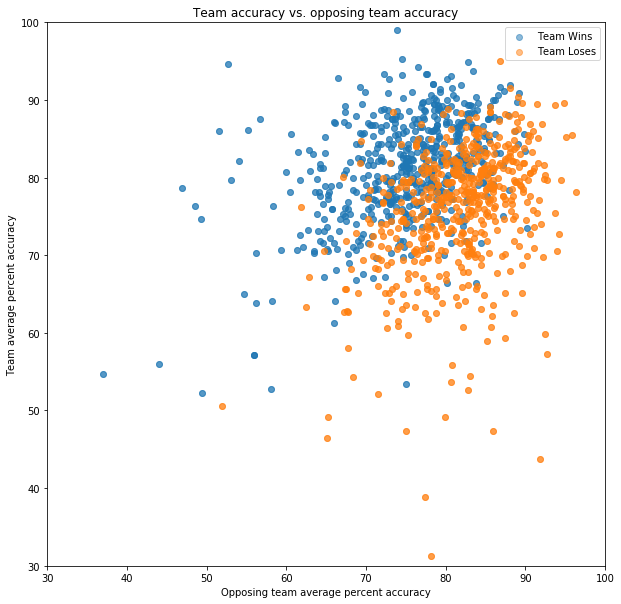

In [97]:
#Let's take a look at the data now.  We'll draw a scatter plot of primary_avg_pct vs. opposing_avg_pct, with blue points
#for primary wins, and orange points for primary loses.
fig2, ax2 = plt.subplots(figsize=(10,10))
primary_wins = plt.scatter(df[df["primary_final_score"] > df["opposing_final_score"]]["opposing_avg_pct"],df[df["primary_final_score"] > df["opposing_final_score"]]["primary_avg_pct"], alpha=0.5, label = "Team Wins")
primary_loses = plt.scatter(df[df["primary_final_score"] < df["opposing_final_score"]]["opposing_avg_pct"],df[df["primary_final_score"] < df["opposing_final_score"]]["primary_avg_pct"], alpha=0.5, label = "Team Loses")
ax2.set_ylabel("Team average percent accuracy")
ax2.set_xlabel("Opposing team average percent accuracy")
ax2.set_title("Team accuracy vs. opposing team accuracy")
plt.xlim(30,100)
plt.ylim(30,100)


So, just looking at this plot, we see that the average accuracy does indeed relate to whether a given team wins or loses a game, and it looks like a linear decision boundary may be reasonable in this case.  (This also matches our intuition that the team that's shooting more accurately should win the game.  i.e. one would expect y = x to be the decision boundary.)  Therefore, it looks like logistic regression would be a suitable technique to use on this data.

In [98]:
#First, let's create training and test sets.  Also, let's create a primary_wins column to feed into our model for
#training and testing.  We'll use 70% of the data for training, and the remaining 30% for testing.
final_df["primary_wins"] = final_df["primary_final_score"] > final_df["opposing_final_score"]
final_df

,game_id,primary_team,primary_avg_pct,opposing_avg_pct,primary_final_score,opposing_final_score,primary_wins
0,169,red,75.000000,81.329114,4,6,False
2,170,red,72.321429,77.678571,3,10,False
5,171,yellow,88.281250,83.593750,9,4,True
6,172,red,70.486111,76.041667,3,7,False
9,173,yellow,86.458333,81.597222,8,3,True
...,...,...,...,...,...,...,...
2191,1264,yellow,86.458333,76.736111,8,2,True
2192,1265,red,86.805556,70.486111,8,4,True
2194,1266,red,71.562500,70.253165,6,4,True
2197,1267,yellow,75.000000,85.312500,3,6,False


In [104]:
#Also note: There are no ties in this dataset.
(final_df["primary_final_score"] == final_df["opposing_final_score"]).value_counts()

False    1100
dtype: int64

In [107]:
#Now, split it up into training and test sets using sklearn's train_test_split
from sklearn.model_selection import train_test_split

train, test = train_test_split(final_df, test_size=0.3)

In [108]:
train

,game_id,primary_team,primary_avg_pct,opposing_avg_pct,primary_final_score,opposing_final_score,primary_wins
189,263,yellow,78.437500,83.437500,3,8,False
638,488,red,82.291667,81.944444,7,3,True
274,306,red,85.416667,95.833333,4,9,False
1720,1029,red,90.312500,89.062500,7,8,False
600,469,red,75.625000,73.750000,6,7,False
...,...,...,...,...,...,...,...
793,565,yellow,71.830986,64.236111,10,4,True
1258,798,red,80.696203,60.000000,7,5,True
32,185,red,78.472222,73.958333,4,8,False
1526,932,red,73.958333,84.722222,4,10,False


In [109]:
test

,game_id,primary_team,primary_avg_pct,opposing_avg_pct,primary_final_score,opposing_final_score,primary_wins
718,528,red,85.000000,78.125000,8,9,False
1453,895,yellow,87.025316,81.962025,7,4,True
23,180,yellow,79.687500,78.437500,6,5,True
521,429,yellow,72.187500,73.750000,4,7,False
1459,898,yellow,89.453125,78.515625,6,2,True
...,...,...,...,...,...,...,...
346,342,red,77.678571,64.285714,15,7,True
1519,928,yellow,68.181818,68.181818,7,10,False
343,340,yellow,80.937500,81.962025,6,8,False
1267,802,yellow,91.406250,79.296875,8,4,True


In [110]:
#Import the LogisticRegression model from SKLearn
from sklearn.linear_model import LogisticRegression

In [117]:
#Create the classifier and fit it to the training data.
clf = LogisticRegression()
clf.fit(train.loc[:,"primary_avg_pct":"opposing_avg_pct"],train["primary_wins"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [120]:
#Now, let's run this model on the test data, and see what the accuracy is.
clf.score(test.loc[:,"primary_avg_pct":"opposing_avg_pct"],test["primary_wins"])

0.8212121212121212

This simple logistic regression model considering the accuracies of the two teams is able to predict the win/loss outcome of the team correctly 82% of the time.  Let's a take a more detailed look at this model now.

In [178]:
#Let's plot the probability map of the model by making a continuous grid of values and evaluating the probability at each
#each point.
xx, yy = np.mgrid[30:100:0.1, 30:100:0.1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:,0].reshape(xx.shape)

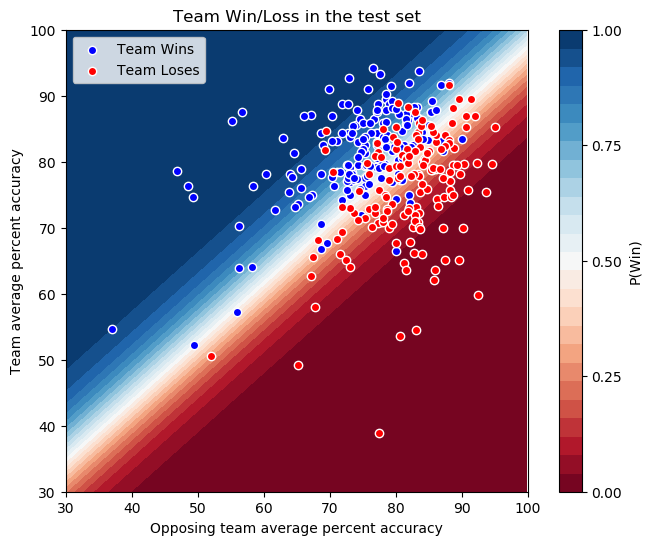

In [197]:
#Now, plot this grid as a contour map, and show the test points on top of it.
fig3, ax3 = plt.subplots(figsize=(8,6))

#The contour plot.
contour = ax3.contourf(xx,yy,probs,25, cmap="RdBu", vmin=0, vmax=1)

#The color legend.
ax_c = fig3.colorbar(contour)
ax_c.set_label("P(Win)")
ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])

#Primary wins in the test set.
primary_wins = plt.scatter(test[test["primary_wins"]]["opposing_avg_pct"], test[test["primary_wins"]]["primary_avg_pct"], color="blue", edgecolor="white", linewidth=1, label = "Team Wins")
primary_loses = plt.scatter(test[test["primary_wins"] == False]["opposing_avg_pct"], test[test["primary_wins"] == False]["primary_avg_pct"], color="red", edgecolor="white", linewidth=1, label = "Team Loses")
ax3.set(aspect="equal", xlim=(30,100), ylim=(30,100), ylabel="Team average percent accuracy", xlabel="Opposing team average percent accuracy",title="Team Win/Loss in the test set")
ax3.legend()

This result is interesting.  The decision boundary here (the white P(Win) = 0.50 line) appears to have a positive y-intercept, and a slope that is less than one.  This is perplexing, as there is nothing special about the "primary team" compared to the "opposing team" -- we went through great trouble to choose these designations randomly, so we would expect our decision boundary to be exactly y = x.  So where could this bias be coming from?  Let's look at the training data. 

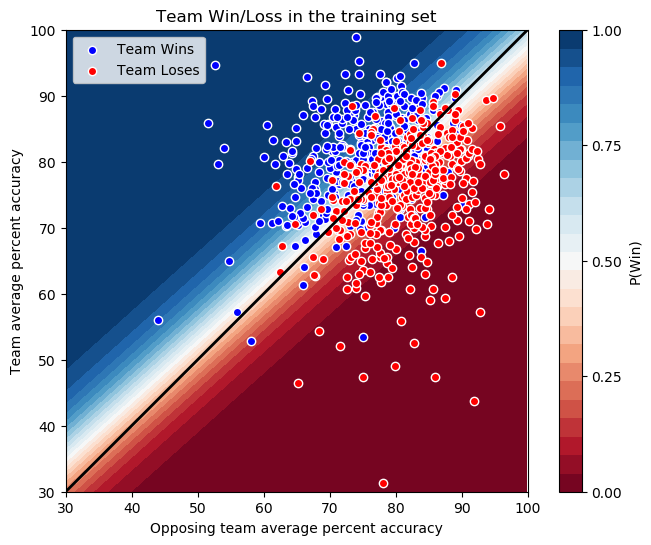

In [211]:
#Same as the previous plot, but with the training set.
fig4, ax4 = plt.subplots(figsize=(8,6))

#The contour plot.
contour = ax4.contourf(xx,yy,probs,25, cmap="RdBu", vmin=0, vmax=1)

#The color legend.
ax_c = fig4.colorbar(contour)
ax_c.set_label("P(Win)")
ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])

#Primary wins in the train set.
primary_wins_train = plt.scatter(train[train["primary_wins"]]["opposing_avg_pct"], train[train["primary_wins"]]["primary_avg_pct"], color="blue", edgecolor="white", linewidth=1, label = "Team Wins")
primary_loses_train = plt.scatter(train[train["primary_wins"] == False]["opposing_avg_pct"], train[train["primary_wins"] == False]["primary_avg_pct"], color="red", edgecolor="white", linewidth=1, label = "Team Loses")
ax4.set(aspect="equal", xlim=(30,100), ylim=(30,100), ylabel="Team average percent accuracy", xlabel="Opposing team average percent accuracy",title="Team Win/Loss in the training set")
ax4.legend()

#Let's also add y = x in to guide the eye.
y_eq_x = np.linspace(30,100,700)
plt.plot(y_eq_x, y_eq_x, color="black", linewidth=2)


In [212]:
#Now, let's run this model on the training data, and see what the accuracy is.
clf.score(train.loc[:,"primary_avg_pct":"opposing_avg_pct"],train["primary_wins"])

0.7675324675324675

In this plot, y = x has been superimposed on to help guide the eye.  So there are a few things to consider here:
1.  The majority of the points are clustered between 60% and 90% accuracy, and in that range the model is pretty close to a y = x decision boundary.
2.  We should keep in mind that the relationship between accuracy and win/loss is not necessarily neat.  There is a strategy component to success, and sometimes a very accurate shot at the right time, or a very inaccurate shot at the wrong time can have a large impact on the score.
    * For example, one shot made or missed by the skip can determine win/loss in a close game, regardless of how accurately they were shooting during the game.
    
    
So, it's maybe no surprise that the logistic regression model can be drawn away from the expected y = x decision boundary, depending on the specific games in the training set.  The logistic regression model actually has slightly worse accuracy on the training set than it does the test set.

The conclusion we can draw here though is that there does seem to be a relationship between the percent accuracy during a game and the Win/Loss outcome of the game, and logistic regression can predict this outcome.  Where this could actually be useful is if we could predict the outcome of a future game based on a team's average performance.  The real benefit of logistic regression in this scenario is that we could provide a probability attached to the Win/Loss prediction.  The question is, does the team's average percent accuracy over many games, compared to the opposing teams, predict the win/loss strongly enough?  Let's find out.

Now, within an event, a team's name code refers to the same team.  Ideally, the situation we would use this model in is to compute the average accuracy of a team over all of "round robin" play at the beginning of the event, then use these values to predict who would win in the playoffs, semi-finals, and finals.  However, there are relatively few data points available for that specific situation (only 24 events in the dataset means 24 final games maximum... not enough for a good model.)  

However, if we're assuming that a team's average performance is a good predictor of a team's performance in another game, we can use all the games in our dataset, and just use the average over the games in the event in our model, instead of the average over just the shots in the single game in question.

This may be a pretty big assumption though:  There's definitely room for a team's stats to improve over the course of an event (or get worse.)  So the average performance model may be too simplistic... but the only way to find out is to give it a try.

In [285]:
#So, we need an SQL query that computes the average for each team in an event, and assigns it to a column for each game
#that team plays in the event.  We can then perform the same manipulation we did before to input to a new logistic
#regression model.
#So we need to group by event and team name.
#Having everything categorized by stone color and the teams broken down by that makes this a little more complicated.
#Handling this just in straight SQL gets cumbersome fast, so let's just pull out red and yellow dataframes for each team
#team name and event, then set about combining them in pandas.  We just need the averages for each team and the number
#of shots that the average is based on.
#Also need to group by games.type here, as we don't want to average together Mens and Women's games in an event if
#the same country sent teams for both categories.

q = """
SELECT events.id AS event_id, games.team_red AS team, games.type, AVG(shots.percent_score) AS avg_pct, COUNT(shots.id) AS n_shots FROM games
INNER JOIN events on events.id = games.event_id
INNER JOIN ends on games.id = ends.game_id
INNER JOIN shots on ends.id = shots.end_id
WHERE games.final_score_red != 'NaN' 
    AND final_score_yellow != "NaN"
    AND shots.color = "red"
GROUP BY events.id, games.team_red, games.type
"""
df_red = db.run_query(q)
df_red

,event_id,team,type,avg_pct,n_shots
0,4,AUT,Men,72.272727,440
1,4,CZE,Women,76.854839,310
2,4,DEN,Men,78.305085,295
3,4,DEN,Women,73.888889,360
4,4,FIN,Men,77.574526,369
...,...,...,...,...,...
257,23,RUS,Women,71.180556,72
258,23,SUI,Women,71.562500,80
259,23,SWE,Men,73.750000,160
260,23,SWE,Women,82.968750,160


In [286]:
q = """
SELECT events.id AS event_id, games.team_yellow AS team, games.type, AVG(shots.percent_score) AS avg_pct, COUNT(shots.id) AS n_shots FROM games
INNER JOIN events on events.id = games.event_id
INNER JOIN ends on games.id = ends.game_id
INNER JOIN shots on ends.id = shots.end_id
WHERE games.final_score_red != 'NaN' 
    AND final_score_yellow != "NaN"
    AND shots.color = "yellow"
GROUP BY events.id, games.team_yellow, games.type
"""
df_yellow = db.run_query(q)
df_yellow

,event_id,team,type,avg_pct,n_shots
0,4,AUT,Men,74.905303,264
1,4,CZE,Women,75.874486,486
2,4,DEN,Men,79.202279,351
3,4,DEN,Women,73.700306,327
4,4,FIN,Men,79.800000,375
...,...,...,...,...,...
253,23,RUS,Women,76.388889,72
254,23,SUI,Women,74.291498,247
255,23,SWE,Men,82.187500,80
256,23,SWE,Women,77.187500,80


In [287]:
#Alright, now let's make a combined dataframe where we have the event_id, team_name, avg_pct_red, n_shots_red,
#avg_pct_yellow and n_shots_yellow.
#Mainly this method is standing in for the OUTER JOIN we'd need to do in the SQL query, but that SQLite doesn't
#natively support.
df_combined = df_red.merge(df_yellow, how="outer", left_on=["event_id", "team", "type"], right_on=["event_id", "team","type"], suffixes=["_red", "_yellow"])
df_combined

,event_id,team,type,avg_pct_red,n_shots_red,avg_pct_yellow,n_shots_yellow
0,4,AUT,Men,72.272727,440.0,74.905303,264.0
1,4,CZE,Women,76.854839,310.0,75.874486,486.0
2,4,DEN,Men,78.305085,295.0,79.202279,351.0
3,4,DEN,Women,73.888889,360.0,73.700306,327.0
4,4,FIN,Men,77.574526,369.0,79.800000,375.0
...,...,...,...,...,...,...,...
277,15,SWE,Women,NaN,NaN,75.390625,64.0
278,15,USA,Men,NaN,NaN,81.515152,165.0
279,15,USA,Women,NaN,NaN,80.000000,80.0
280,23,CAN,Women,NaN,NaN,82.812500,224.0


In [288]:
#Now, we can see some NaN values, because apparently in some events some of the teams only ever used the same color of
#rocks.  Since we're averaging things together though, we can just replace all the NaN values with 0.0 and the math
#math will work out.
df_combined[df_combined["n_shots_red"].isna()]

,event_id,team,type,avg_pct_red,n_shots_red,avg_pct_yellow,n_shots_yellow
262,7,FIN,Men,NaN,NaN,70.312500,64.0
263,7,FIN,Women,NaN,NaN,54.687500,80.0
264,9,AUS,Women,NaN,NaN,55.937500,80.0
265,9,CHN,Women,NaN,NaN,75.312500,80.0
266,9,NZL,Men,NaN,NaN,68.359375,64.0
267,10,AUS,Women,NaN,NaN,55.937500,80.0
268,10,CHN,Women,NaN,NaN,77.878289,304.0
269,10,NZL,Men,NaN,NaN,69.166667,120.0
270,13,HUN,Women,NaN,NaN,64.583333,48.0
271,13,JPN,Women,NaN,NaN,98.958333,48.0


In [289]:
df_combined[df_combined["n_shots_yellow"].isna()]

,event_id,team,type,avg_pct_red,n_shots_red,avg_pct_yellow,n_shots_yellow
60,7,DEN,Women,65.000000,80.0,NaN,NaN
61,7,ITA,Men,81.640625,64.0,NaN,NaN
77,9,AUS,Men,71.093750,64.0,NaN,NaN
78,9,JPN,Women,79.375000,80.0,NaN,NaN
79,9,NZL,Women,57.187500,80.0,NaN,NaN
80,10,AUS,Men,71.093750,64.0,NaN,NaN
81,10,CHN,Men,80.060729,247.0,NaN,NaN
86,10,NZL,Women,62.171053,152.0,NaN,NaN
123,13,CAN,Women,81.250000,48.0,NaN,NaN
124,13,KOR,Women,71.306818,88.0,NaN,NaN


Ah, what seems to have happened here is these were events where a team ended up shooting very few shots total (in most cases it's less than a game's worth.  What were events 13, 14, and 15?

In [291]:
q = """
SELECT id, name FROM events
WHERE id > 12 AND id < 16
"""
db.run_query(q)

,id,name
0,13,CUR_WJCC2017T
1,14,CUR_WJCC2018P
2,15,CUR_WJCC2019P


These 3 were World Juniors events.  Maybe there was early elmination here?  Let's take a look through 13, CUR_WJCC2017T to see if we can spot the issue.

For this one, we only have one session's worth of data.  How about 14, CUR_WJCC_2018P?  That again seems to be a small number of session files.  SUI played more than 1 game in these files, but happened to get the same rock color more than once.

What this does show us though is that sometimes the "average over an event" might be equal to the percentage average over one game:

In [293]:
df_combined[df_combined["n_shots_red"].isna()].shape

(20, 7)

In [294]:
df_combined[df_combined["n_shots_yellow"].isna()].shape

(24, 7)

So this occurs in 44 out of 282 pairing teams.  At almost 20%, that's potentially large enough to skew our model to being better than it otherwise should be.  We should keep this in mind later (we might want to apply a cut based on how many shots the average is based off of, before defining our training and test sets.)  For now, let's just sub in 0 for NaN, so we can make our calculations.

In [298]:
df_combined = df_combined.fillna(0)
df_combined["total_shots"] = df_combined["n_shots_red"] + df_combined["n_shots_yellow"]
df_combined

,event_id,team,type,avg_pct_red,n_shots_red,avg_pct_yellow,n_shots_yellow,total_shots
0,4,AUT,Men,72.272727,440.0,74.905303,264.0,704.0
1,4,CZE,Women,76.854839,310.0,75.874486,486.0,796.0
2,4,DEN,Men,78.305085,295.0,79.202279,351.0,646.0
3,4,DEN,Women,73.888889,360.0,73.700306,327.0,687.0
4,4,FIN,Men,77.574526,369.0,79.800000,375.0,744.0
...,...,...,...,...,...,...,...,...
277,15,SWE,Women,0.000000,0.0,75.390625,64.0,64.0
278,15,USA,Men,0.000000,0.0,81.515152,165.0,165.0
279,15,USA,Women,0.000000,0.0,80.000000,80.0,80.0
280,23,CAN,Women,0.000000,0.0,82.812500,224.0,224.0


In [300]:
df_combined["avg_pct"] = (df_combined["avg_pct_red"]*df_combined["n_shots_red"] + df_combined["avg_pct_yellow"]*df_combined["n_shots_yellow"])/df_combined["total_shots"]
df_combined

,event_id,team,type,avg_pct_red,n_shots_red,avg_pct_yellow,n_shots_yellow,total_shots,avg_pct
0,4,AUT,Men,72.272727,440.0,74.905303,264.0,704.0,73.259943
1,4,CZE,Women,76.854839,310.0,75.874486,486.0,796.0,76.256281
2,4,DEN,Men,78.305085,295.0,79.202279,351.0,646.0,78.792570
3,4,DEN,Women,73.888889,360.0,73.700306,327.0,687.0,73.799127
4,4,FIN,Men,77.574526,369.0,79.800000,375.0,744.0,78.696237
...,...,...,...,...,...,...,...,...,...
277,15,SWE,Women,0.000000,0.0,75.390625,64.0,64.0,75.390625
278,15,USA,Men,0.000000,0.0,81.515152,165.0,165.0,81.515152
279,15,USA,Women,0.000000,0.0,80.000000,80.0,80.0,80.000000
280,23,CAN,Women,0.000000,0.0,82.812500,224.0,224.0,82.812500


So now we have a table with the average percentage for each team in each event.  So, we need to pull the same table as we did earlier in this study, but this time including the necessary team identifiers  as well (event_id, team, and type.)

In [320]:
q = """
SELECT games.event_id, games.id AS game_id, games.team_red, games.team_yellow, games.type, games.final_score_red, games.final_score_yellow, shots.color,  AVG(shots.percent_score) AS avg_pct FROM games
INNER JOIN ends on games.id = ends.game_id
INNER JOIN shots on ends.id = shots.end_id
WHERE games.final_score_red != 'NaN' AND final_score_yellow != "NaN"
GROUP BY games.id, shots.color
"""

#Call this df_ea for "event average"
df_ea = db.run_query(q)
df_ea

,event_id,game_id,team_red,team_yellow,type,final_score_red,final_score_yellow,color,avg_pct
0,4,169,AUT,SUI,Men,4,6,red,75.000000
1,4,169,AUT,SUI,Men,4,6,yellow,81.329114
2,4,170,FIN,NOR,Men,3,10,red,72.321429
3,4,170,FIN,NOR,Men,3,10,yellow,77.678571
4,4,171,GER,SWE,Men,4,9,red,83.593750
...,...,...,...,...,...,...,...,...,...
2195,23,1266,SUI,GBR,Women,6,4,yellow,70.253165
2196,23,1267,SWE,SUI,Women,6,3,red,85.312500
2197,23,1267,SWE,SUI,Women,6,3,yellow,75.000000
2198,23,1268,RUS,CAN,Women,3,8,red,71.180556


Now we perform the same manipulation that we did earlier, reshaping the data into primary and opposing teams.  Do this randomly again.

In [327]:
df_ea["primary_team"] = pd.Series(np.random.randint(0,2,size=df["game_id"].size).repeat(2)).map(pt_map)
df_ea

,event_id,game_id,team_red,team_yellow,type,final_score_red,final_score_yellow,color,avg_pct,primary_team
0,4,169,AUT,SUI,Men,4,6,red,75.000000,red
1,4,169,AUT,SUI,Men,4,6,yellow,81.329114,red
2,4,170,FIN,NOR,Men,3,10,red,72.321429,red
3,4,170,FIN,NOR,Men,3,10,yellow,77.678571,red
4,4,171,GER,SWE,Men,4,9,red,83.593750,red
...,...,...,...,...,...,...,...,...,...,...
2195,23,1266,SUI,GBR,Women,6,4,yellow,70.253165,red
2196,23,1267,SWE,SUI,Women,6,3,red,85.312500,yellow
2197,23,1267,SWE,SUI,Women,6,3,yellow,75.000000,yellow
2198,23,1268,RUS,CAN,Women,3,8,red,71.180556,red


In [328]:
df_ea["primary_team"].value_counts()

yellow    1142
red       1058
Name: primary_team, dtype: int64

In [329]:
df_ea["primary_avg_pct"] = df_ea[df_ea["color"] == df_ea["primary_team"]]["avg_pct"]
df_ea

,event_id,game_id,team_red,team_yellow,type,final_score_red,final_score_yellow,color,avg_pct,primary_team,primary_avg_pct
0,4,169,AUT,SUI,Men,4,6,red,75.000000,red,75.000000
1,4,169,AUT,SUI,Men,4,6,yellow,81.329114,red,NaN
2,4,170,FIN,NOR,Men,3,10,red,72.321429,red,72.321429
3,4,170,FIN,NOR,Men,3,10,yellow,77.678571,red,NaN
4,4,171,GER,SWE,Men,4,9,red,83.593750,red,83.593750
...,...,...,...,...,...,...,...,...,...,...,...
2195,23,1266,SUI,GBR,Women,6,4,yellow,70.253165,red,NaN
2196,23,1267,SWE,SUI,Women,6,3,red,85.312500,yellow,NaN
2197,23,1267,SWE,SUI,Women,6,3,yellow,75.000000,yellow,75.000000
2198,23,1268,RUS,CAN,Women,3,8,red,71.180556,red,71.180556


In [330]:
df_ea["opposing_avg_pct"] = df_ea[df_ea["color"] != df_ea["primary_team"]]["avg_pct"]
df_ea

,event_id,game_id,team_red,team_yellow,type,final_score_red,final_score_yellow,color,avg_pct,primary_team,primary_avg_pct,opposing_avg_pct
0,4,169,AUT,SUI,Men,4,6,red,75.000000,red,75.000000,NaN
1,4,169,AUT,SUI,Men,4,6,yellow,81.329114,red,NaN,81.329114
2,4,170,FIN,NOR,Men,3,10,red,72.321429,red,72.321429,NaN
3,4,170,FIN,NOR,Men,3,10,yellow,77.678571,red,NaN,77.678571
4,4,171,GER,SWE,Men,4,9,red,83.593750,red,83.593750,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2195,23,1266,SUI,GBR,Women,6,4,yellow,70.253165,red,NaN,70.253165
2196,23,1267,SWE,SUI,Women,6,3,red,85.312500,yellow,NaN,85.312500
2197,23,1267,SWE,SUI,Women,6,3,yellow,75.000000,yellow,75.000000,NaN
2198,23,1268,RUS,CAN,Women,3,8,red,71.180556,red,71.180556,NaN


In [332]:
df_ea["primary_avg_pct"] = df_ea["primary_avg_pct"].dropna().repeat(2).to_numpy()
df_ea["opposing_avg_pct"] = df_ea["opposing_avg_pct"].dropna().repeat(2).to_numpy()
df_ea


,event_id,game_id,team_red,team_yellow,type,final_score_red,final_score_yellow,color,avg_pct,primary_team,primary_avg_pct,opposing_avg_pct
0,4,169,AUT,SUI,Men,4,6,red,75.000000,red,75.000000,81.329114
1,4,169,AUT,SUI,Men,4,6,yellow,81.329114,red,75.000000,81.329114
2,4,170,FIN,NOR,Men,3,10,red,72.321429,red,72.321429,77.678571
3,4,170,FIN,NOR,Men,3,10,yellow,77.678571,red,72.321429,77.678571
4,4,171,GER,SWE,Men,4,9,red,83.593750,red,83.593750,88.281250
...,...,...,...,...,...,...,...,...,...,...,...,...
2195,23,1266,SUI,GBR,Women,6,4,yellow,70.253165,red,71.562500,70.253165
2196,23,1267,SWE,SUI,Women,6,3,red,85.312500,yellow,75.000000,85.312500
2197,23,1267,SWE,SUI,Women,6,3,yellow,75.000000,yellow,75.000000,85.312500
2198,23,1268,RUS,CAN,Women,3,8,red,71.180556,red,71.180556,77.083333


In [336]:
#Actually, might have been able to accomplish this better with indexing.  Try and do that to get the team name in the
#right format.
df_ea.loc[df_ea["primary_team"] == "red", "primary_name"] = df_ea["team_red"]
df_ea.loc[df_ea["primary_team"] == "yellow", "primary_name"] = df_ea["team_yellow"]
df_ea.loc[df_ea["primary_team"] == "red", "opposing_name"] = df_ea["team_yellow"]
df_ea.loc[df_ea["primary_team"] == "yellow", "opposing_name"] = df_ea["team_red"]

df_ea

,event_id,game_id,team_red,team_yellow,type,final_score_red,final_score_yellow,color,avg_pct,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name
0,4,169,AUT,SUI,Men,4,6,red,75.000000,red,75.000000,81.329114,AUT,SUI
1,4,169,AUT,SUI,Men,4,6,yellow,81.329114,red,75.000000,81.329114,AUT,SUI
2,4,170,FIN,NOR,Men,3,10,red,72.321429,red,72.321429,77.678571,FIN,NOR
3,4,170,FIN,NOR,Men,3,10,yellow,77.678571,red,72.321429,77.678571,FIN,NOR
4,4,171,GER,SWE,Men,4,9,red,83.593750,red,83.593750,88.281250,GER,SWE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,23,1266,SUI,GBR,Women,6,4,yellow,70.253165,red,71.562500,70.253165,SUI,GBR
2196,23,1267,SWE,SUI,Women,6,3,red,85.312500,yellow,75.000000,85.312500,SUI,SWE
2197,23,1267,SWE,SUI,Women,6,3,yellow,75.000000,yellow,75.000000,85.312500,SUI,SWE
2198,23,1268,RUS,CAN,Women,3,8,red,71.180556,red,71.180556,77.083333,RUS,CAN


In [337]:
#Alright, that was much easier than what I did before for getting the numbers in the right slot. Let's assign primary
#and opposing final score as we did before.
df_ea = df_ea.assign(primary_final_score=df_ea["final_score_yellow"].where(df_ea["primary_team"] == "yellow",df_ea["final_score_red"]))
df_ea

,event_id,game_id,team_red,team_yellow,type,final_score_red,final_score_yellow,color,avg_pct,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score
0,4,169,AUT,SUI,Men,4,6,red,75.000000,red,75.000000,81.329114,AUT,SUI,4
1,4,169,AUT,SUI,Men,4,6,yellow,81.329114,red,75.000000,81.329114,AUT,SUI,4
2,4,170,FIN,NOR,Men,3,10,red,72.321429,red,72.321429,77.678571,FIN,NOR,3
3,4,170,FIN,NOR,Men,3,10,yellow,77.678571,red,72.321429,77.678571,FIN,NOR,3
4,4,171,GER,SWE,Men,4,9,red,83.593750,red,83.593750,88.281250,GER,SWE,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,23,1266,SUI,GBR,Women,6,4,yellow,70.253165,red,71.562500,70.253165,SUI,GBR,6
2196,23,1267,SWE,SUI,Women,6,3,red,85.312500,yellow,75.000000,85.312500,SUI,SWE,3
2197,23,1267,SWE,SUI,Women,6,3,yellow,75.000000,yellow,75.000000,85.312500,SUI,SWE,3
2198,23,1268,RUS,CAN,Women,3,8,red,71.180556,red,71.180556,77.083333,RUS,CAN,3


In [338]:
df_ea = df_ea.assign(opposing_final_score=df_ea["final_score_yellow"].where(df_ea["primary_team"] == "red",df_ea["final_score_red"]))
df_ea

,event_id,game_id,team_red,team_yellow,type,final_score_red,final_score_yellow,color,avg_pct,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score
0,4,169,AUT,SUI,Men,4,6,red,75.000000,red,75.000000,81.329114,AUT,SUI,4,6
1,4,169,AUT,SUI,Men,4,6,yellow,81.329114,red,75.000000,81.329114,AUT,SUI,4,6
2,4,170,FIN,NOR,Men,3,10,red,72.321429,red,72.321429,77.678571,FIN,NOR,3,10
3,4,170,FIN,NOR,Men,3,10,yellow,77.678571,red,72.321429,77.678571,FIN,NOR,3,10
4,4,171,GER,SWE,Men,4,9,red,83.593750,red,83.593750,88.281250,GER,SWE,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,23,1266,SUI,GBR,Women,6,4,yellow,70.253165,red,71.562500,70.253165,SUI,GBR,6,4
2196,23,1267,SWE,SUI,Women,6,3,red,85.312500,yellow,75.000000,85.312500,SUI,SWE,3,6
2197,23,1267,SWE,SUI,Women,6,3,yellow,75.000000,yellow,75.000000,85.312500,SUI,SWE,3,6
2198,23,1268,RUS,CAN,Women,3,8,red,71.180556,red,71.180556,77.083333,RUS,CAN,3,8


In [340]:
#Remove rows where the color is not equal to the primary team.
df_ea_final = df_ea[df_ea["color"] == df_ea["primary_team"]]

#Now, drop the columns we don't need.
df_ea_final = df_ea.drop(["team_red", "team_yellow","final_score_red", "final_score_yellow", "color", "avg_pct"], axis=1)
df_ea_final

,event_id,game_id,type,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score
0,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6
1,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6
2,4,170,Men,red,72.321429,77.678571,FIN,NOR,3,10
3,4,170,Men,red,72.321429,77.678571,FIN,NOR,3,10
4,4,171,Men,red,83.593750,88.281250,GER,SWE,4,9
...,...,...,...,...,...,...,...,...,...,...
2195,23,1266,Women,red,71.562500,70.253165,SUI,GBR,6,4
2196,23,1267,Women,yellow,75.000000,85.312500,SUI,SWE,3,6
2197,23,1267,Women,yellow,75.000000,85.312500,SUI,SWE,3,6
2198,23,1268,Women,red,71.180556,77.083333,RUS,CAN,3,8


Now, to get in the average percentage over the whole event (and the n_shots it's based off of) for each team, we merge twice:
1.  Once by joining on event_id, primary_name, and type to populate the primary team's numbers for a game.
2.  Once by joining on event_id, opposing_name, and type to populate the opposing team's numbers for the game.

This can be an inner merge, because all teams should be represented in both dataframes.

In [343]:
df_all = df_ea_final.merge(df_combined, how="inner", left_on=["event_id", "primary_name", "type"], right_on=["event_id", "team","type"], suffixes=["", "_event"])
df_all

,event_id,game_id,type,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score,team,avg_pct_red,n_shots_red,avg_pct_yellow,n_shots_yellow,total_shots,avg_pct
0,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,AUT,72.272727,440.0,74.905303,264.0,704.0,73.259943
1,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,AUT,72.272727,440.0,74.905303,264.0,704.0,73.259943
2,4,179,Men,red,64.236111,81.250000,AUT,ITA,6,9,AUT,72.272727,440.0,74.905303,264.0,704.0,73.259943
3,4,179,Men,red,64.236111,81.250000,AUT,ITA,6,9,AUT,72.272727,440.0,74.905303,264.0,704.0,73.259943
4,4,194,Men,yellow,74.218750,71.875000,AUT,DEN,9,3,AUT,72.272727,440.0,74.905303,264.0,704.0,73.259943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,23,1262,Women,yellow,68.125000,66.250000,GBR,NOR,7,6,GBR,58.333333,72.0,69.182390,159.0,231.0,65.800866
2196,23,1264,Women,red,76.736111,86.458333,KOR,CAN,2,8,KOR,81.770833,144.0,0.000000,0.0,144.0,81.770833
2197,23,1264,Women,red,76.736111,86.458333,KOR,CAN,2,8,KOR,81.770833,144.0,0.000000,0.0,144.0,81.770833
2198,23,1265,Women,red,86.805556,70.486111,KOR,GER,8,4,KOR,81.770833,144.0,0.000000,0.0,144.0,81.770833


In [345]:
#Drop the columns we don't need.
df_all = df_all.drop(["team", "avg_pct_red", "n_shots_red", "avg_pct_yellow", "n_shots_yellow"], axis=1)
df_all

,event_id,game_id,type,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score,total_shots,avg_pct
0,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943
1,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943
2,4,179,Men,red,64.236111,81.250000,AUT,ITA,6,9,704.0,73.259943
3,4,179,Men,red,64.236111,81.250000,AUT,ITA,6,9,704.0,73.259943
4,4,194,Men,yellow,74.218750,71.875000,AUT,DEN,9,3,704.0,73.259943
...,...,...,...,...,...,...,...,...,...,...,...,...
2195,23,1262,Women,yellow,68.125000,66.250000,GBR,NOR,7,6,231.0,65.800866
2196,23,1264,Women,red,76.736111,86.458333,KOR,CAN,2,8,144.0,81.770833
2197,23,1264,Women,red,76.736111,86.458333,KOR,CAN,2,8,144.0,81.770833
2198,23,1265,Women,red,86.805556,70.486111,KOR,GER,8,4,144.0,81.770833


In [348]:
#Change the total_shots and avg_pct columns to reflect that they are for the primary team.
df_all = df_all.rename(columns={"total_shots":"primary_total_shots_event", "avg_pct":"primary_avg_pct_event"})
df_all

,event_id,game_id,type,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score,primary_total_shots_event,primary_avg_pct_event
0,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943
1,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943
2,4,179,Men,red,64.236111,81.250000,AUT,ITA,6,9,704.0,73.259943
3,4,179,Men,red,64.236111,81.250000,AUT,ITA,6,9,704.0,73.259943
4,4,194,Men,yellow,74.218750,71.875000,AUT,DEN,9,3,704.0,73.259943
...,...,...,...,...,...,...,...,...,...,...,...,...
2195,23,1262,Women,yellow,68.125000,66.250000,GBR,NOR,7,6,231.0,65.800866
2196,23,1264,Women,red,76.736111,86.458333,KOR,CAN,2,8,144.0,81.770833
2197,23,1264,Women,red,76.736111,86.458333,KOR,CAN,2,8,144.0,81.770833
2198,23,1265,Women,red,86.805556,70.486111,KOR,GER,8,4,144.0,81.770833


In [349]:
df_all = df_all.merge(df_combined, how="inner", left_on=["event_id", "opposing_name", "type"], right_on=["event_id", "team","type"], suffixes=["", "_event"])
df_all

,event_id,game_id,type,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score,primary_total_shots_event,primary_avg_pct_event,team,avg_pct_red,n_shots_red,avg_pct_yellow,n_shots_yellow,total_shots,avg_pct
0,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943,SUI,83.184524,336.0,82.976445,467.0,803.0,83.063512
1,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943,SUI,83.184524,336.0,82.976445,467.0,803.0,83.063512
2,4,187,Men,yellow,75.000000,82.031250,GER,SUI,2,7,664.0,80.082831,SUI,83.184524,336.0,82.976445,467.0,803.0,83.063512
3,4,187,Men,yellow,75.000000,82.031250,GER,SUI,2,7,664.0,80.082831,SUI,83.184524,336.0,82.976445,467.0,803.0,83.063512
4,4,207,Men,yellow,82.500000,83.125000,NOR,SUI,7,3,837.0,84.378734,SUI,83.184524,336.0,82.976445,467.0,803.0,83.063512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,23,1265,Women,red,86.805556,70.486111,KOR,GER,8,4,144.0,81.770833,GER,83.238636,88.0,70.486111,72.0,160.0,77.500000
2196,23,1267,Women,yellow,75.000000,85.312500,SUI,SWE,3,6,327.0,73.623853,SWE,82.968750,160.0,77.187500,80.0,240.0,81.041667
2197,23,1267,Women,yellow,75.000000,85.312500,SUI,SWE,3,6,327.0,73.623853,SWE,82.968750,160.0,77.187500,80.0,240.0,81.041667
2198,23,1262,Women,yellow,68.125000,66.250000,GBR,NOR,7,6,231.0,65.800866,NOR,66.250000,80.0,65.178571,56.0,136.0,65.808824


In [350]:
#Drop the columns we don't need.
df_all = df_all.drop(["team", "avg_pct_red", "n_shots_red", "avg_pct_yellow", "n_shots_yellow"], axis=1)
df_all

,event_id,game_id,type,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score,primary_total_shots_event,primary_avg_pct_event,total_shots,avg_pct
0,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943,803.0,83.063512
1,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943,803.0,83.063512
2,4,187,Men,yellow,75.000000,82.031250,GER,SUI,2,7,664.0,80.082831,803.0,83.063512
3,4,187,Men,yellow,75.000000,82.031250,GER,SUI,2,7,664.0,80.082831,803.0,83.063512
4,4,207,Men,yellow,82.500000,83.125000,NOR,SUI,7,3,837.0,84.378734,803.0,83.063512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,23,1265,Women,red,86.805556,70.486111,KOR,GER,8,4,144.0,81.770833,160.0,77.500000
2196,23,1267,Women,yellow,75.000000,85.312500,SUI,SWE,3,6,327.0,73.623853,240.0,81.041667
2197,23,1267,Women,yellow,75.000000,85.312500,SUI,SWE,3,6,327.0,73.623853,240.0,81.041667
2198,23,1262,Women,yellow,68.125000,66.250000,GBR,NOR,7,6,231.0,65.800866,136.0,65.808824


In [351]:
#Change the total_shots and avg_pct columns to reflect that they are for the opposing team.
df_all = df_all.rename(columns={"total_shots":"opposing_total_shots_event", "avg_pct":"opposing_avg_pct_event"})
df_all

,event_id,game_id,type,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score,primary_total_shots_event,primary_avg_pct_event,opposing_total_shots_event,opposing_avg_pct_event
0,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943,803.0,83.063512
1,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943,803.0,83.063512
2,4,187,Men,yellow,75.000000,82.031250,GER,SUI,2,7,664.0,80.082831,803.0,83.063512
3,4,187,Men,yellow,75.000000,82.031250,GER,SUI,2,7,664.0,80.082831,803.0,83.063512
4,4,207,Men,yellow,82.500000,83.125000,NOR,SUI,7,3,837.0,84.378734,803.0,83.063512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,23,1265,Women,red,86.805556,70.486111,KOR,GER,8,4,144.0,81.770833,160.0,77.500000
2196,23,1267,Women,yellow,75.000000,85.312500,SUI,SWE,3,6,327.0,73.623853,240.0,81.041667
2197,23,1267,Women,yellow,75.000000,85.312500,SUI,SWE,3,6,327.0,73.623853,240.0,81.041667
2198,23,1262,Women,yellow,68.125000,66.250000,GBR,NOR,7,6,231.0,65.800866,136.0,65.808824


These merges have duplicated some rows, so use drop_duplicates to get rid of them (each should have a unique game_id, but we'll just filter on whole row duplication.)

In [366]:
df_all_final = df_all.drop_duplicates(keep="first")
df_all_final

,event_id,game_id,type,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score,primary_total_shots_event,primary_avg_pct_event,opposing_total_shots_event,opposing_avg_pct_event
0,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943,803.0,83.063512
2,4,187,Men,yellow,75.000000,82.031250,GER,SUI,2,7,664.0,80.082831,803.0,83.063512
4,4,207,Men,yellow,82.500000,83.125000,NOR,SUI,7,3,837.0,84.378734,803.0,83.063512
6,4,215,Men,red,90.625000,80.555556,NOR,SUI,7,4,837.0,84.378734,803.0,83.063512
8,4,217,Men,yellow,79.687500,82.187500,RUS,SUI,6,8,847.0,81.139315,803.0,83.063512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,23,1260,Women,yellow,65.178571,46.428571,NOR,KAZ,10,4,136.0,65.808824,56.0,46.428571
2192,23,1263,Women,yellow,77.586207,83.238636,SUI,GER,5,4,327.0,73.623853,160.0,77.500000
2194,23,1265,Women,red,86.805556,70.486111,KOR,GER,8,4,144.0,81.770833,160.0,77.500000
2196,23,1267,Women,yellow,75.000000,85.312500,SUI,SWE,3,6,327.0,73.623853,240.0,81.041667


In [367]:
#Finally, let's add in the "primary_wins" column.
df_all_final["primary_wins"] = df_all_final["primary_final_score"] > df_all_final["opposing_final_score"]
df_all_final

/home/myslik/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,event_id,game_id,type,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score,primary_total_shots_event,primary_avg_pct_event,opposing_total_shots_event,opposing_avg_pct_event,primary_wins
0,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943,803.0,83.063512,False
2,4,187,Men,yellow,75.000000,82.031250,GER,SUI,2,7,664.0,80.082831,803.0,83.063512,False
4,4,207,Men,yellow,82.500000,83.125000,NOR,SUI,7,3,837.0,84.378734,803.0,83.063512,True
6,4,215,Men,red,90.625000,80.555556,NOR,SUI,7,4,837.0,84.378734,803.0,83.063512,True
8,4,217,Men,yellow,79.687500,82.187500,RUS,SUI,6,8,847.0,81.139315,803.0,83.063512,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,23,1260,Women,yellow,65.178571,46.428571,NOR,KAZ,10,4,136.0,65.808824,56.0,46.428571,True
2192,23,1263,Women,yellow,77.586207,83.238636,SUI,GER,5,4,327.0,73.623853,160.0,77.500000,True
2194,23,1265,Women,red,86.805556,70.486111,KOR,GER,8,4,144.0,81.770833,160.0,77.500000,True
2196,23,1267,Women,yellow,75.000000,85.312500,SUI,SWE,3,6,327.0,73.623853,240.0,81.041667,False


In [369]:
#Now we can analyze the data.  First, let's only keep games where the team's average percent accuracy over the event is 
#based on more than 100 shots (there would be 80 shots in a typical game).  As mentioned before, we do this so we don't
#have unrealistically good averages in our dataset.
df_all_final = df_all_final[(df_all_final["primary_total_shots_event"] > 100) & (df_all_final["opposing_total_shots_event"] > 100)]
df_all_final

,event_id,game_id,type,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score,primary_total_shots_event,primary_avg_pct_event,opposing_total_shots_event,opposing_avg_pct_event,primary_wins
0,4,169,Men,red,75.000000,81.329114,AUT,SUI,4,6,704.0,73.259943,803.0,83.063512,False
2,4,187,Men,yellow,75.000000,82.031250,GER,SUI,2,7,664.0,80.082831,803.0,83.063512,False
4,4,207,Men,yellow,82.500000,83.125000,NOR,SUI,7,3,837.0,84.378734,803.0,83.063512,True
6,4,215,Men,red,90.625000,80.555556,NOR,SUI,7,4,837.0,84.378734,803.0,83.063512,True
8,4,217,Men,yellow,79.687500,82.187500,RUS,SUI,6,8,847.0,81.139315,803.0,83.063512,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2188,23,1261,Women,yellow,70.000000,75.632911,SUI,CHN,6,4,327.0,73.623853,159.0,74.685535,True
2192,23,1263,Women,yellow,77.586207,83.238636,SUI,GER,5,4,327.0,73.623853,160.0,77.500000,True
2194,23,1265,Women,red,86.805556,70.486111,KOR,GER,8,4,144.0,81.770833,160.0,77.500000,True
2196,23,1267,Women,yellow,75.000000,85.312500,SUI,SWE,3,6,327.0,73.623853,240.0,81.041667,False


At the level of "games", that's only 23 games out of 1100, so it wouldn't make too much of a difference here anyway.  Now let's look at the full dataset.

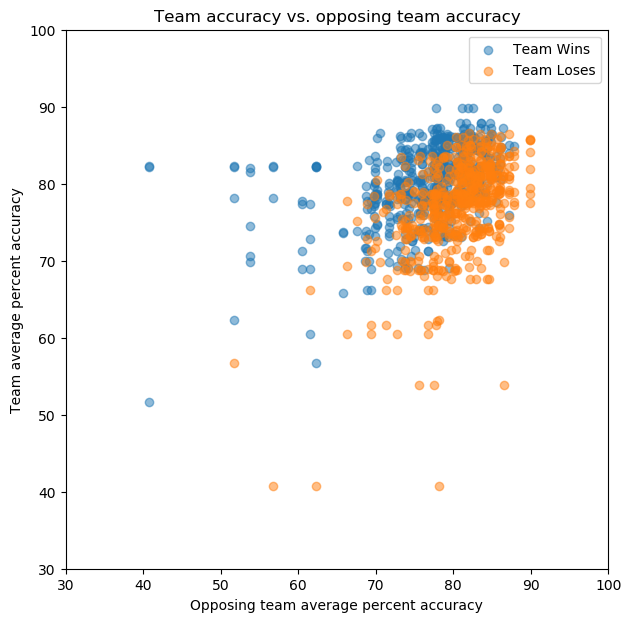

In [376]:
fige1, axe1 = plt.subplots(figsize=(7,7))
primary_wins = plt.scatter(df_all_final[df_all_final["primary_wins"]]["opposing_avg_pct_event"],df_all_final[df_all_final["primary_wins"]]["primary_avg_pct_event"], alpha=0.5, label = "Team Wins")
primary_wins = plt.scatter(df_all_final[~df_all_final["primary_wins"]]["opposing_avg_pct_event"],df_all_final[~df_all_final["primary_wins"]]["primary_avg_pct_event"], alpha=0.5, label = "Team Loses")
axe1.set_ylabel("Team average percent accuracy")
axe1.set_xlabel("Opposing team average percent accuracy")
axe1.set_title("Team accuracy vs. opposing team accuracy")
plt.xlim(30,100)
plt.ylim(30,100)
axe1.legend()

So, we see that it looks like there still is some discriminatory power here, though we are dealing with a much tighter cluster of points. (This is to be expected, having averaged each team's performance over multiple games.)  So, let's go ahead and train a logistic regression model using this data, and see how well it does.

In [377]:
train_e, test_e = train_test_split(df_all_final, test_size=0.3)

In [378]:
train_e

,event_id,game_id,type,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score,primary_total_shots_event,primary_avg_pct_event,opposing_total_shots_event,opposing_avg_pct_event,primary_wins
306,5,332,Women,yellow,81.562500,74.367089,DEN,CZE,6,3,623.0,73.996790,676.0,76.812130,True
242,5,289,Men,yellow,79.062500,79.062500,ITA,NOR,5,8,624.0,79.246795,847.0,82.497048,False
2020,22,1173,Men,red,85.227273,75.568182,DEN,KOR,9,8,695.0,82.086331,694.0,82.312680,True
1282,17,810,Men,yellow,81.562500,81.875000,SUI,CHN,5,6,934.0,80.995717,903.0,81.007752,False
1584,18,912,Women,yellow,76.988636,73.579545,CHN,CZE,7,8,878.0,73.320046,836.0,72.607656,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,19,1039,Women,red,89.204545,90.909091,RUS,SWE,8,9,1041.0,83.597502,878.0,87.158314,False
1182,16,770,Men,red,88.839286,80.357143,NOR,USA,3,9,822.0,82.542579,885.0,81.949153,False
56,4,205,Men,yellow,82.102273,79.545455,FIN,GER,6,5,744.0,78.696237,664.0,80.082831,True
494,6,445,Women,red,80.312500,72.812500,DEN,CZE,5,3,694.0,75.468300,684.0,74.232456,True


In [379]:
test_e

,event_id,game_id,type,primary_team,primary_avg_pct,opposing_avg_pct,primary_name,opposing_name,primary_final_score,opposing_final_score,primary_total_shots_event,primary_avg_pct_event,opposing_total_shots_event,opposing_avg_pct_event,primary_wins
624,8,494,Men,red,81.250000,77.840909,DEN,ITA,5,6,670.0,82.574627,614.0,77.850163,False
1944,21,1145,Men,yellow,83.750000,84.062500,USA,JPN,8,6,1054.0,82.352941,957.0,84.247649,True
660,8,499,Women,red,78.164557,65.384615,CZE,LAT,9,5,471.0,78.715499,478.0,69.979079,True
562,6,453,Women,yellow,82.911392,77.812500,RUS,SCO,8,7,846.0,80.230496,686.0,79.482507,True
1166,16,788,Men,red,85.763889,81.944444,USA,GER,8,5,885.0,81.949153,814.0,79.453317,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,16,778,Men,red,80.937500,90.625000,NED,SUI,6,9,776.0,78.672680,1038.0,84.128131,False
834,11,596,Women,yellow,36.979167,54.687500,QAT,KAZ,1,11,360.0,40.763889,384.0,56.770833,False
1270,16,805,Men,red,87.500000,86.708861,CAN,SWE,7,4,823.0,89.854192,1005.0,85.696517,True
1240,16,761,Men,yellow,84.375000,63.020833,CHN,NED,9,3,774.0,81.879845,776.0,78.672680,True


In [390]:
clf_e = LogisticRegression()
clf_e.fit(train_e.loc[:,["primary_avg_pct_event","opposing_avg_pct_event"]],train_e["primary_wins"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [391]:
#First, how does it do on the training set:
clf_e.score(train_e.loc[:,["primary_avg_pct_event","opposing_avg_pct_event"]],train_e["primary_wins"])

0.7423638778220452

In [393]:
#Now, on the test set.
clf_e.score(test_e.loc[:,["primary_avg_pct_event","opposing_avg_pct_event"]],test_e["primary_wins"])

0.7314814814814815

So, from a team's average performance we can predict the winning team in a match accurately almost 75% of the time.  This would seem to indicate that individual teams are overall pretty consistent in their shooting accuracy, and there is a pretty good relationship between this accuracy and the game's outcome, as we established with the in-game accuracy percentages.  Let's go ahead and draw the probability map for this logistic regression model, with the training data, and y=x to guide the eye.

In [394]:
#Make the grid points for the probability map:
xx, yy = np.mgrid[30:100:0.1, 30:100:0.1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf_e.predict_proba(grid)[:,0].reshape(xx.shape)

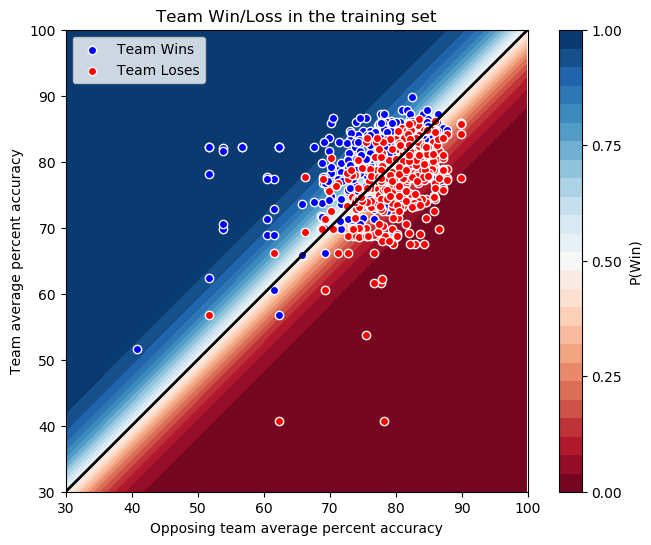

In [397]:
#Same as the previous plot, but with the training set.
fige2, axe2 = plt.subplots(figsize=(8,6))

#The contour plot.
contour = axe2.contourf(xx,yy,probs,25, cmap="RdBu", vmin=0, vmax=1)

#The color legend.
ax_c = fige2.colorbar(contour)
ax_c.set_label("P(Win)")
ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])

#Primary wins in the train set.
primary_wins_train_e = plt.scatter(train_e[train_e["primary_wins"]]["opposing_avg_pct_event"], train_e[train_e["primary_wins"]]["primary_avg_pct_event"], color="blue", edgecolor="white", linewidth=1, label = "Team Wins")
primary_loses_train_e = plt.scatter(train_e[train_e["primary_wins"] == False]["opposing_avg_pct_event"], train_e[train_e["primary_wins"] == False]["primary_avg_pct_event"], color="red", edgecolor="white", linewidth=1, label = "Team Loses")
axe2.set(aspect="equal", xlim=(30,100), ylim=(30,100), ylabel="Team average percent accuracy", xlabel="Opposing team average percent accuracy",title="Team Win/Loss in the training set")
axe2.legend()

#Let's also add y = x in to guide the eye.
y_eq_x = np.linspace(30,100,700)
plt.plot(y_eq_x, y_eq_x, color="black", linewidth=2)

### Conclusions
In this case, our logistic regression model appears to have found y = x as the decision boundary, which is what we expected.  The area between 0 and 1 probability of the team winning is more compressed here, which is also expected, given that the event-wide average points are more tightly clustered than the individual game averages.

Another useful feature of the logistic regression model is that it outputs probabilities of the classes, not just the class identifier.  How accurate these probability estimates are is something that is probably worth additional investigation.  However, I reserve that for looking deeper into Win/Loss prediction at a later date.  As mentioned at the beginning of this study, there is much more than can be considered:
* How accurate is a team's shooting as a function of time?
* Do we gain more discriminating power by breaking the averages down by position (lead, second, vice, skip)?
* Do we gain more discriminating power by breaking the averages down by shot type, as is typically done during games by the commentators?
* How is all of this related to the score differential of the game?

One thing is for sure:  There is a relationship between a team's accuracy compared to their opponent and whether they win or lose the game.  Looking into these questions is therefore worthwhile to see if we can come up with a more accurate model.  The only real application of the current model is sports betting.  Incorporating some of the above questions makes the model more valuable to coaching, as you could target your practice in improving accuracy in areas most likely to have the highest impact on your team's success.